# Problem Set 7, Part Two: Due Tuesday, March 25 by 8am Eastern Daylight Time

## Name: David Millard

**Show your work on all problems!** Be sure to give credit to any
collaborators, or outside sources used in solving the problems. Note
that if using an outside source to do a calculation, you should use it
as a reference for the method, and actually carry out the calculation
yourself; it’s not sufficient to quote the results of a calculation
contained in an outside source.

Fill in your solutions in the notebook below, inserting markdown and/or code cells as needed.  Try to do reasonably well with the typesetting, but don't feel compelled to replicate my formatting exactly.  **You do NOT need to make random variables blue!**

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0,5.0)
plt.rcParams['font.size'] = 14

# Null Distribution for Friedman Test

The purpose of this problem is to test the assertion that the chi-squared approximation in the standard Friedman test, which claims that
$$
T_1 = \frac{12}{bk(k+1)}\sum_{j=1}^k \left(R_j-\frac{b(k+1)}{2}\right)^2
$$
is approximately $\chi^2(k-1)$ distributed, should be replaced with the $F$-statistic approximation, which claims that
$$
T_2 = \frac{(b-1)T_1}{b(k-1)-T_1}
$$
is $F(k-1,(b-1)(k-1))$ distributed.  We will test the two approximations for $b=5$, $k=3$, by constructing the exact null distribution, and comparing the associated $p$-values for all the possible statistic values with those for the two approximations.

First we construct the full list of $(k!)^b$ sets of possible ranks $R_{ij}$

In [3]:
b = 5
k = 3
import itertools
ranks_I_j = [ranks_j for ranks_j in itertools.permutations(1+np.arange(k))]
R_Iij = np.array([R_ij for R_ij in itertools.product(ranks_I_j,repeat=b)])

There are $(3!)^5=6^5=7776$ possibilities, each of which is a list of $5$ permutations of the ranks $1,2,3$.  (5 blocks, 3 treatments)  We examine the first and last few.

In [4]:
print(R_Iij.shape)
print(R_Iij[:2])
print(R_Iij[-2:])

(7776, 5, 3)
[[[1 2 3]
  [1 2 3]
  [1 2 3]
  [1 2 3]
  [1 2 3]]

 [[1 2 3]
  [1 2 3]
  [1 2 3]
  [1 2 3]
  [1 3 2]]]
[[[3 2 1]
  [3 2 1]
  [3 2 1]
  [3 2 1]
  [3 1 2]]

 [[3 2 1]
  [3 2 1]
  [3 2 1]
  [3 2 1]
  [3 2 1]]]


Now we construct $R_j=\sum_{i=1}^b R_{ij}$ which is a list of $k=3$ rank sums for each of the $7776$ possible outcomes (equally likely under the null hypothesis).

In [5]:
R_Ij = np.sum(R_Iij,axis=1)
print(R_Ij.shape)
print(R_Ij[:2])
print(R_Ij[-2:])

(7776, 3)
[[ 5 10 15]
 [ 5 11 14]]
[[15  9  6]
 [15 10  5]]


We convert the rank-sums for each outcome into a statistic $T_1$.  We can check the mean and variance of this distribution and compare it to those for the approximate $\chi^2$ distribution:

In [6]:
Rbar = 0.5*b*(k+1); Rbar
sigsqR = b*k*(k+1)/12; sigsqR
T1_I = np.sum((R_Ij-Rbar)**2,axis=-1)/sigsqR
print(np.mean(T1_I))
print(np.var(T1_I))
print(stats.chi2(df=k-1).mean())
print(stats.chi2(df=k-1).var())

2.0
3.2000000000000006
2.0
4.0


We see that the means match, but the variance is overestimated by the $\chi^2$ approximation.

We can plot the exact pmf:

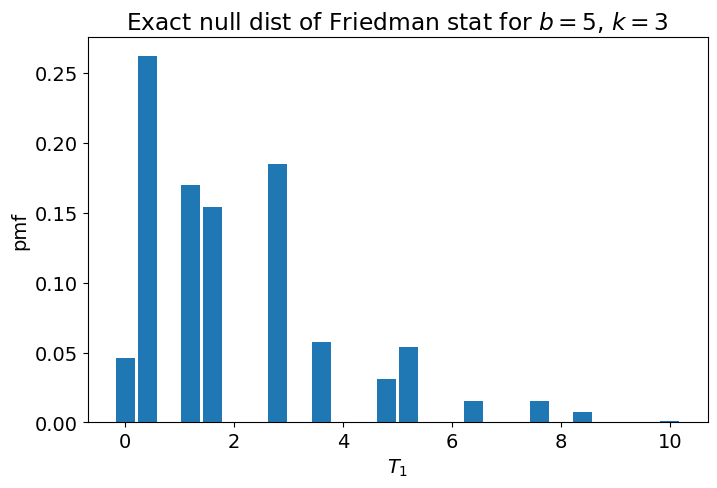

In [7]:
T1vals = np.unique(T1_I)
T1pmf = np.mean(T1_I[None,:]==T1vals[:,None],axis=-1)
plt.bar(T1vals,T1pmf,0.35);
plt.xlabel(r'$T_1$');
plt.ylabel('pmf');
plt.title('Exact null dist of Friedman stat for $b=%d$, $k=%d$' % (b,k));

Note that there are only 12 possible values of the statistic.

In [8]:
print(T1vals)

[ 0.   0.4  1.2  1.6  2.8  3.6  4.8  5.2  6.4  7.6  8.4 10. ]


  We can calculate the tail probability $P(T_1\ge t_1)$ for each of these values, and compare to the values under the chi-squared approximation.

In [9]:
tailprobs = np.mean(T1_I[None,:]>=T1vals[:,None],axis=-1)
print(tailprobs)
T1tailapprox = stats.chi2(df=k-1).sf(T1vals)
print(T1tailapprox)

[1.00000000e+00 9.53703704e-01 6.91358025e-01 5.21604938e-01
 3.67283951e-01 1.82098765e-01 1.24228395e-01 9.33641975e-02
 3.93518519e-02 2.39197531e-02 8.48765432e-03 7.71604938e-04]
[1.         0.81873075 0.54881164 0.44932896 0.24659696 0.16529889
 0.09071795 0.07427358 0.0407622  0.02237077 0.01499558 0.00673795]


We can also convert the values to the transformed $T_2$ statistic.

In [10]:
T2vals = (b-1)*T1vals/(b*(k-1)-T1vals)
print(T2vals)

[ 0.          0.16666667  0.54545455  0.76190476  1.55555556  2.25
  3.69230769  4.33333333  7.11111111 12.66666667 21.                 inf]


/tmp/ipykernel_1895678/1777234283.py:1: RuntimeWarning: divide by zero encountered in divide
  T2vals = (b-1)*T1vals/(b*(k-1)-T1vals)


Note that when $T_1=10=b(k-1)$, $T_2=\infty$.  This means we can't really talk about $E(T_2)$ or $V(T_2)$.

We can calculate the tail probabilties $P(T_2\ge t_2)$ according to the $F$-distribution approximation.  (Since the mapping of $T_1$ to $T_2$ is invertible, we don't need to re-calculate the exact tail probabilities.)

In [11]:
T2tailapprox = stats.f(k-1,(b-1)*(k-1)).sf(T2vals)
print(T2tailapprox)

[1.0000000e+00 8.4934656e-01 5.9969536e-01 4.9787136e-01 2.6873856e-01
 1.6777216e-01 7.3116160e-02 5.3084160e-02 1.6796160e-02 3.3177600e-03
 6.5536000e-04 0.0000000e+00]


Now we plot the two different approximations to the tail probabilities versus the exact probability:

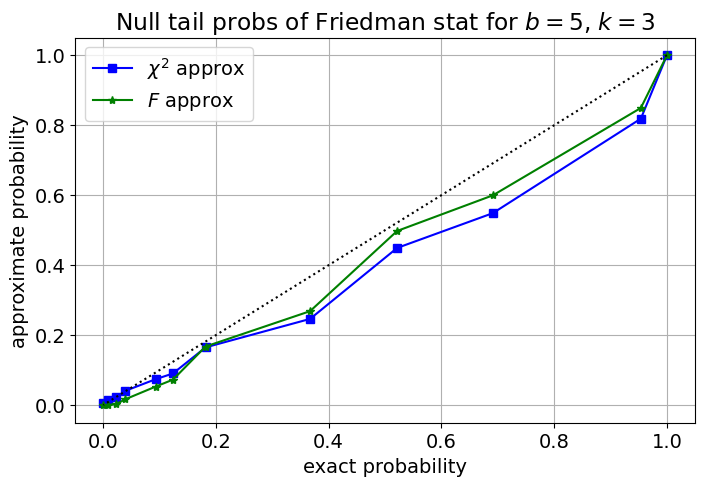

In [12]:
plt.plot(tailprobs,T1tailapprox,'bs-',label=r'$\chi^2$ approx');
plt.plot(tailprobs,T2tailapprox,'g*-',label=r'$F$ approx');
plt.plot(tailprobs,tailprobs,'k:')
plt.xlabel('exact probability')
plt.ylabel('approximate probability')
plt.title('Null tail probs of Friedman stat for $b=%d$, $k=%d$' % (b,k));
plt.grid(True);
plt.legend(loc='upper left');

**(a)** Comment on the accuracy of the two approximations.  Under what circumstances is the $F$ approximation better?  Under what circumstances is the $\chi^2$ better?

The $F$ approximation tends to perform better across most of the range. When the exact probability is low the approximation is worse.

The $\chi ^2$ approximation tends to perform at lower $p$-values. When the exact proability is $<2$ it performs better than the $F$ approximation.

**(b)** Low $p$-values are of particular interest; in order to focus on those, remake the plot above on a log scale using `plt.loglog()` rather than `plt.plot()`.

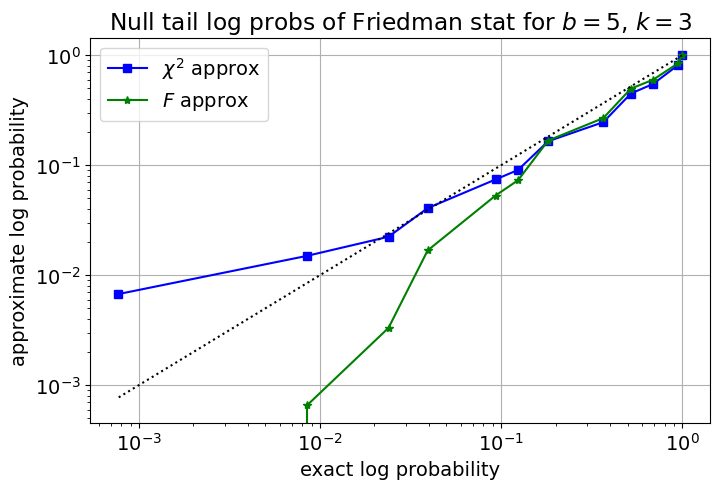

In [13]:
plt.loglog(tailprobs,T1tailapprox,'bs-',label=r'$\chi^2$ approx');
plt.loglog(tailprobs,T2tailapprox,'g*-',label=r'$F$ approx');
plt.loglog(tailprobs,tailprobs,'k:')
plt.xlabel('exact log probability')
plt.ylabel('approximate log probability')
plt.title('Null tail log probs of Friedman stat for $b=%d$, $k=%d$' % (b,k));
plt.grid(True);
plt.legend(loc='upper left');

**(c)** How do the two approximations perform at low $p$-values?  Which is conservative (overestimates $p$-values) and which is liberal (underestimates $p$-values)?

The $F$ approximation is worse at low $p$-values. The $\chi^2$ approximation is better at low $p$-values.

The $\chi^2$ approximation is conservative while the $F$ approximation is liberal.